In [38]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns



In [39]:
ratings = pd.read_csv('data/amazon/musical_instruments_ratings.csv')
ratings.head()


,user,item,rating
0,A2IBPI20UZIR0U,1384719342,5.0
1,A14VAT5EAX3D9S,1384719342,5.0
2,A195EZSQDW3E21,1384719342,5.0
3,A2C00NNG1ZQQG2,1384719342,5.0
4,A94QU4C90B1AX,1384719342,5.0


In [40]:
#How many items are in the data set? How many users? How many ratings?

n_ratings = len(ratings)
n_users = ratings['user'].nunique()
n_items = ratings['item'].nunique()

print(f'Number of ratings: {n_ratings}')
print(f'Number of unique users: {n_users}')
print(f'Number of unique items: {n_items}')


Number of ratings: 10261
Number of unique users: 1429
Number of unique items: 900


In [41]:
#User activity:
#What is the distribution of ratings-per-user?
user_freq = ratings[['user', 'rating']].groupby('user').count().reset_index()
user_freq.columns = ['user', 'n_ratings']
user_freq.head()


,user,n_ratings
0,A00625243BI8W1SSZNLMD,8
1,A10044ECXDUVKS,6
2,A102MU6ZC9H1N6,6
3,A109JTUZXO61UY,5
4,A109ME7C09HM2M,5


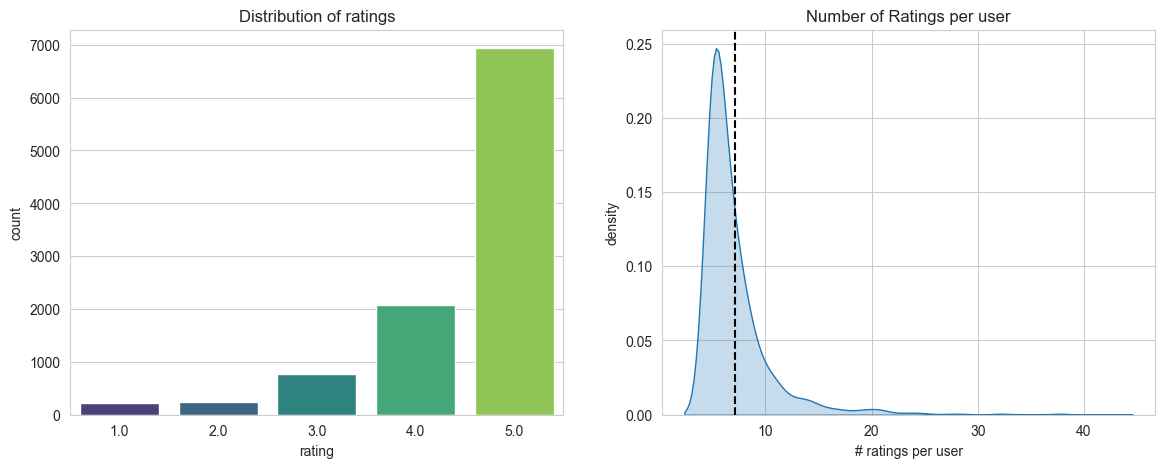

In [42]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of Ratings per user")
plt.show()

In [48]:
#Find most and least active users for all 4 dataset. How many ratings did they provide.

user_active = ratings.groupby('user')['rating'].count()
#user_active.columns = ['n_ratings']

most_active = user_active.idxmax()
least_active = user_active.idxmin()

most_active_ratings = user_active[most_active]
least_active_ratings = user_active[least_active]

print(f"The most active user is {most_active} with {most_active_ratings} ratings.")
print(f"The least active user is {least_active} with {least_active_ratings} ratings.")


The most active user is ADH0O8UVJOT10 with 42 ratings.
The least active user is A109JTUZXO61UY with 5 ratings.


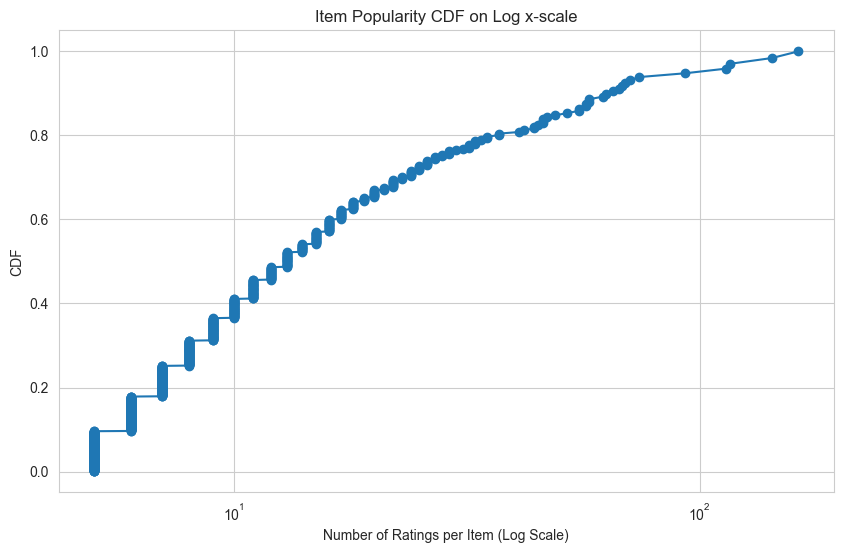

In [49]:
#Item statistics:
#What is the item popularity curve (the distribution of ratings-per-item)? A CDF plot on a log x scale or a rank-frequency plot on a log-log scale.

item_freq = ratings.groupby('item')['rating'].count().reset_index()
item_freq.columns = ['item', 'n_ratings']

item_freq_sort = item_freq.sort_values(by='n_ratings')

cdf = np.cumsum(item_freq_sort['n_ratings']) / np.sum(item_freq_sort['n_ratings'])

plt.figure(figsize=(10, 6))
plt.plot(item_freq_sort['n_ratings'], cdf, marker='o')
plt.xscale('log')
plt.xlabel('Number of Ratings per Item (Log Scale)')
plt.ylabel('CDF')
plt.title('Item Popularity CDF on Log x-scale')
plt.show()



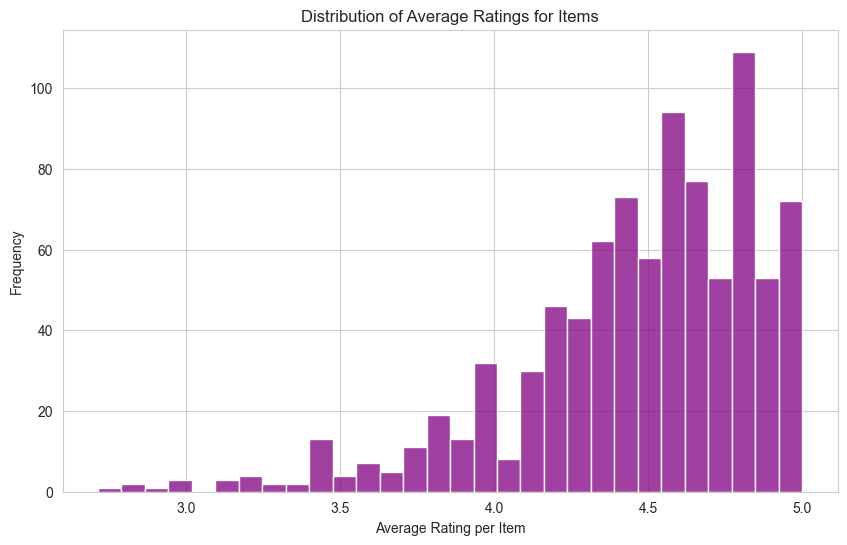

In [50]:
#What is the distribution of average ratings for items?


avg_item_rating = ratings.groupby('item')['rating'].mean().reset_index()
avg_item_rating.columns = ['item', 'avg_rating']

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(avg_item_rating['avg_rating'], bins=30, kde=False, color='purple')
plt.xlabel('Average Rating per Item')
plt.ylabel('Frequency')
plt.title("Distribution of Average Ratings for Items")
plt.show()


In [52]:
#Non-personalized recommendation
#What are the 10 most popular items (the items with the most ratings)? Show the item ID, item title, and the number of ratings.

item_pop = ratings.groupby('item')['rating'].count().reset_index()
item_pop.columns = ['item', 'n_ratings']

top10_item = item_pop.sort_values(by='n_ratings', ascending=False).head(10)

print('The most popular items based on the number of ratings are: \n')
print(top10_item[['item', 'n_ratings']])


The most popular items based on the number of ratings are: 

           item  n_ratings
706  B003VWJ2K8        163
94   B0002E1G5C        143
156  B0002F7K7Y        116
707  B003VWKPHC        114
198  B0002H0A3S         93
44   B0002CZVXM         74
258  B0006NDF8A         71
285  B0009G1E0K         69
116  B0002E2KPC         68
167  B0002GLDQM         67


In [53]:
#What are the 10 items with the highest average ratings (with their titles and average ratings)?

item_avg_rating = ratings.groupby('item')['rating'].mean().reset_index()
item_avg_rating.columns = ['item', 'avg_rating']

top10_avg_rate = item_avg_rating.sort_values(by='avg_rating', ascending=False).head(10)

print('The 10 items with the highest average ratings are: \n')
print(top10_avg_rate)


The 10 items with the highest average ratings are: 

           item  avg_rating
0    1384719342         5.0
669  B003AJMPW4         5.0
604  B0027842S4         5.0
641  B002RLLD88         5.0
288  B0009IEB0I         5.0
283  B0009EU01G         5.0
282  B0009EQOES         5.0
649  B0033P1O6S         5.0
275  B0007Y3XGW         5.0
274  B0007XWUQ2         5.0


In [54]:
#What are the 10 movies with the highest damped average ratings, with a Bayesian damping factor of 5? Show both the damped and undamped mean for these items. You can also use the bias model (without user biases) to compute these means. The damped mean with factor 
 #is computed by: $r^~i=\frac{\Sum{r_{ui}\in R_i}r_{ui}}+\gamma*r^¯)}{|R_i|+ \gamma}$ .
    
overall_mean_rating = ratings['rating'].mean()
gamma = 5

item_stats = ratings.groupby('item')['rating'].agg(['sum', 'count']).reset_index()
item_stats['damped_mean'] = (item_stats['sum'] + gamma * overall_mean_rating) / (item_stats['count'] + gamma)
item_stats['undamped_mean'] = item_stats['sum'] / item_stats['count']

top10_damped_items = item_stats.sort_values(by='damped_mean', ascending=False).head(10)

print('The 10 items with the highest damped average ratings are: \n')
print(top10_damped_items[['item', 'damped_mean', 'undamped_mean']])


The 10 items with the highest damped average ratings are: 

           item  damped_mean  undamped_mean
594  B001W99HE8     4.897749       5.000000
504  B0015RIN6U     4.888866       4.962963
424  B000RKL8R2     4.849631       5.000000
649  B0033P1O6S     4.829581       5.000000
604  B0027842S4     4.829581       5.000000
120  B0002E2XCW     4.828874       4.866667
718  B0042EZH6W     4.826366       4.888889
387  B000L6GD04     4.820089       4.864865
438  B000RY68PA     4.817408       5.000000
669  B003AJMPW4     4.817408       5.000000
